In [1]:
from itertools import combinations

import networkx as nx

import matching.glema.common.utils.arg_utils as arg_utils
import matching.glema.common.utils.graph_utils as graph_utils
import matching.glema.common.utils.misc_utils as misc_utils
import matching.glema.common.utils.model_utils as model_utils
import matching.glema.common.utils.plot_utils as plot_utils
import matching.glema.evaluation.evaluate_pattern_matching as epm
import matching.misc.cpg_const as cpg_const
from matching.glema.common.dataset import DesignPatternDataset

In [2]:
args = arg_utils.parse_args( use_default=True )
args.dataset = "CPG_augm_large"
args.directed = False
args.anchored = True
version = model_utils.get_latest_model_version( args )
model_name = model_utils.get_model_name( args, version )
args = arg_utils.load_args( args, model_name )

args.pattern_dataset = "CPG_all"
args.normalized = True
args.test_data = True

In [3]:
dataset = DesignPatternDataset( args, max_pattern_examples=30, query_pattern=False )
pattern_label_args = {
    "record_scopes": dataset.get_pattern_record_scopes(),
    "design_patterns": dataset.get_patterns()
}

In [4]:
source_pattern_counts = { }
for _, pattern in dataset.get_source_patterns().items():
    if pattern not in source_pattern_counts:
        source_pattern_counts[ pattern ] = 0
    source_pattern_counts[ pattern ] += 1
source_pattern_counts

{'FACTORY_METHOD': 49,
 'N/A': 1022,
 'BUILDER': 25,
 'OBSERVER': 83,
 'FACADE': 7,
 'ADAPTER': 13,
 'ABSTRACT_FACTORY': 16,
 'SINGLETON': 5}

In [5]:
pattern_example_counts = { dp: len( l ) for dp, l in dataset.get_patterns().items() }
pattern_example_counts

{'FACTORY_METHOD': 30,
 'OBSERVER': 30,
 'ADAPTER': 30,
 'BUILDER': 30,
 'FACADE': 30,
 'SINGLETON': 30,
 'ABSTRACT_FACTORY': 30}

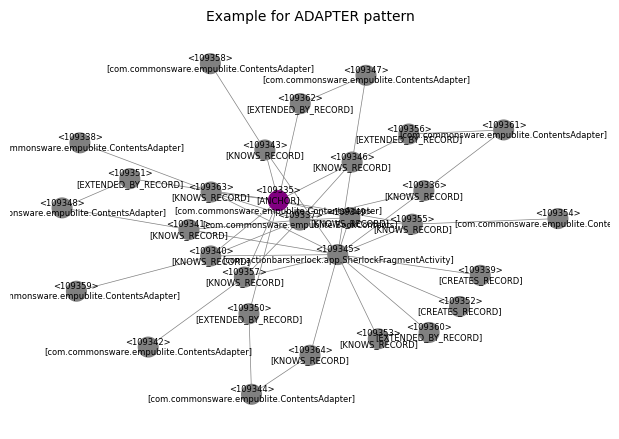

In [6]:
dp_example_type = cpg_const.DesignPatternType.ADAPTER.value
dp_example = dataset.get_patterns()[ dp_example_type ][ 2 ]
plot_utils.plot_graph( dp_example,
                       title=f"Example for {dp_example_type} pattern",
                       nodeColors=graph_utils.get_node_colors( dp_example ),
                       nodeLabels=graph_utils.get_node_labels( dp_example, **pattern_label_args ) )

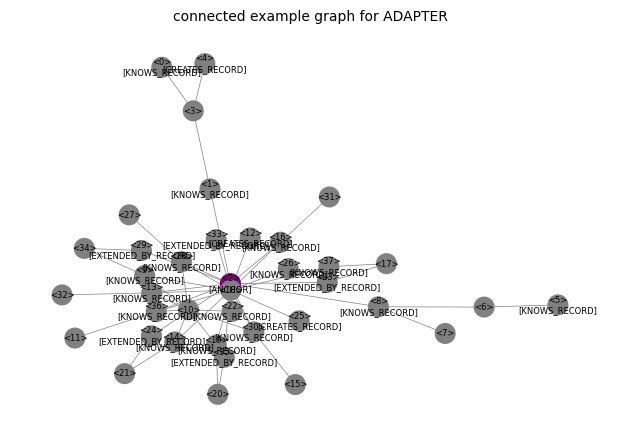

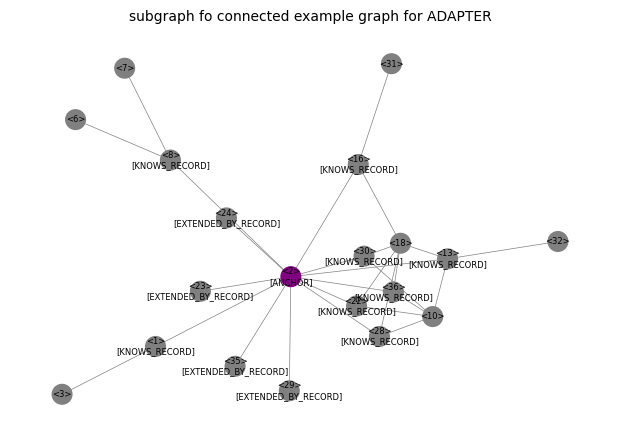

In [7]:
connected_example_graph = graph_utils.connect_graphs_at_anchor(
    dataset.get_patterns()[ dp_example_type ][ :3 ],
    keep_radius=3 )
plot_utils.plot_graph( connected_example_graph,
                       title=f"connected example graph for {dp_example_type}",
                       nodeColors=graph_utils.get_node_colors( connected_example_graph ),
                       nodeLabels=graph_utils.get_node_labels( connected_example_graph ) )

connected_example_graph_subgraph = graph_utils.subgraph_from_anchor_of_size( connected_example_graph, max_n=20 )
plot_utils.plot_graph( connected_example_graph_subgraph,
                       title=f"subgraph fo connected example graph for {dp_example_type}",
                       nodeColors=graph_utils.get_node_colors( connected_example_graph_subgraph ),
                       nodeLabels=graph_utils.get_node_labels( connected_example_graph_subgraph ) )

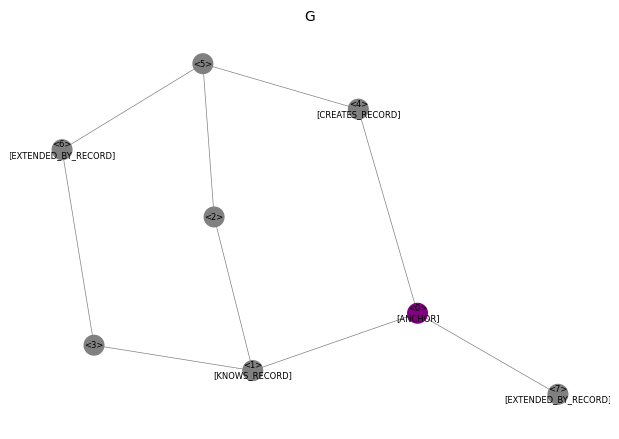

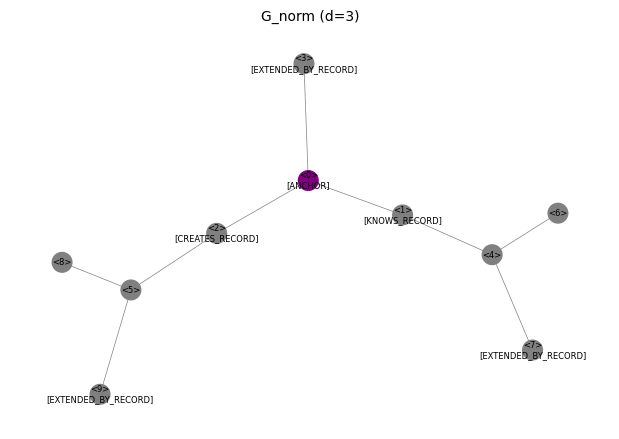

In [8]:
def addCpgNode( G, label: cpg_const.NodeLabel, anchor=False ):
    node_id = G.number_of_nodes()
    anchor_idx = 1 if anchor else 0
    G.add_node( node_id, label=misc_utils.get_enum_idx( label ), anchor=anchor_idx )
    return node_id


# Example usage
G = nx.DiGraph() if args.directed else nx.Graph()
n11 = addCpgNode( G, cpg_const.NodeLabel.RECORD, anchor=True )
n12 = addCpgNode( G, cpg_const.NodeLabel.KNOWS_RECORD )
n13 = addCpgNode( G, cpg_const.NodeLabel.RECORD )
n14 = addCpgNode( G, cpg_const.NodeLabel.RECORD )
n15 = addCpgNode( G, cpg_const.NodeLabel.CREATES_RECORD )
n16 = addCpgNode( G, cpg_const.NodeLabel.RECORD )
n17 = addCpgNode( G, cpg_const.NodeLabel.EXTENDED_BY_RECORD )
n18 = addCpgNode( G, cpg_const.NodeLabel.EXTENDED_BY_RECORD )
G.add_edge( n11, n12 )
G.add_edge( n12, n13 )
G.add_edge( n12, n14 )
G.add_edge( n11, n15 )
G.add_edge( n15, n16 )
G.add_edge( n13, n16 )
G.add_edge( n14, n17 )
G.add_edge( n16, n17 )
G.add_edge( n11, n18 )
plot_utils.plot_graph( G, title="G",
                       nodeLabels=graph_utils.get_node_labels( G ),
                       nodeColors=graph_utils.get_node_colors( G ) )

G_norm, d = graph_utils.normalize_graph( G )
plot_utils.plot_graph( G_norm, title=f"G_norm (d={d})",
                       nodeLabels=graph_utils.get_node_labels( G_norm ),
                       nodeColors=graph_utils.get_node_colors( G_norm ) )

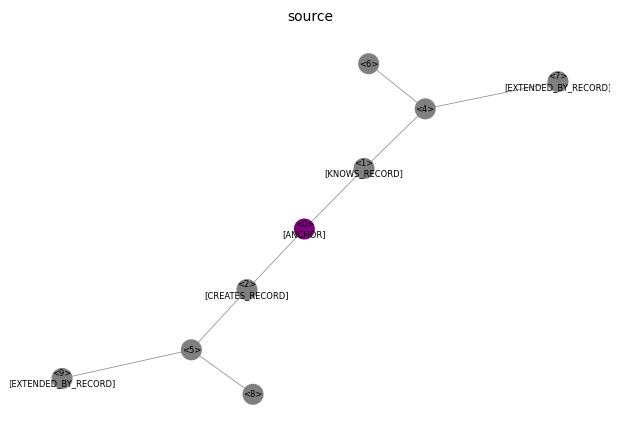

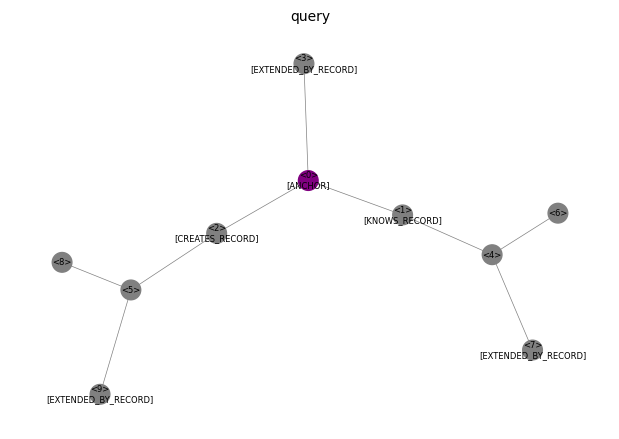

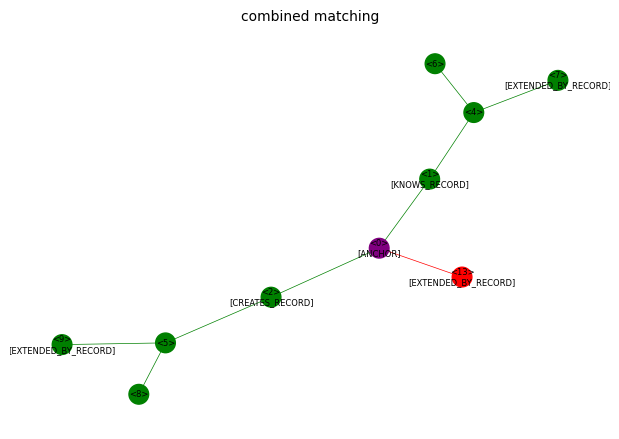

In [9]:
G_source = G_norm.copy()
G_query = G_norm.copy()
G_source.remove_node( 3 )
plot_utils.plot_graph( G_source, title="source",
                       nodeLabels=graph_utils.get_node_labels( G_source ),
                       nodeColors=graph_utils.get_node_colors( G_source ) )
plot_utils.plot_graph( G_query, title="query",
                       nodeLabels=graph_utils.get_node_labels( G_query ),
                       nodeColors=graph_utils.get_node_colors( G_query ) )

matching_colors = { 2: "purple", 1: "green", 0: "grey", -1: "red" }
combined_graph, node_colors, edge_colors = graph_utils.combine_normalized( G_source, G_query,
                                                                           matching_colors=matching_colors )
plot_utils.plot_graph( combined_graph, title="combined matching",
                       nodeLabels=graph_utils.get_node_labels( combined_graph ),
                       nodeColors=node_colors, edgeColors=edge_colors )

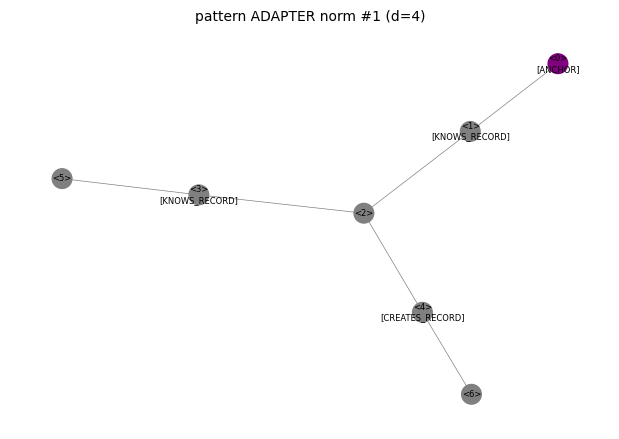

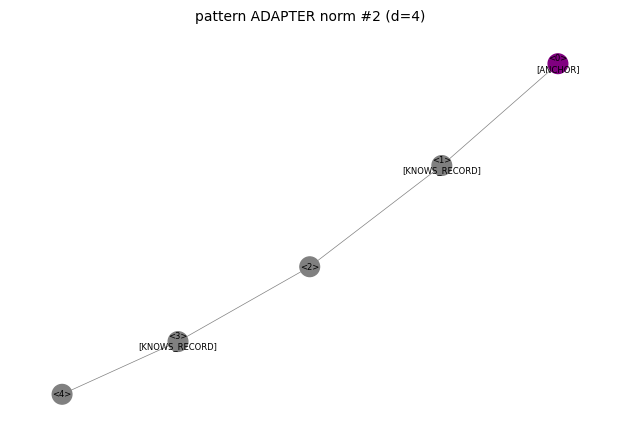

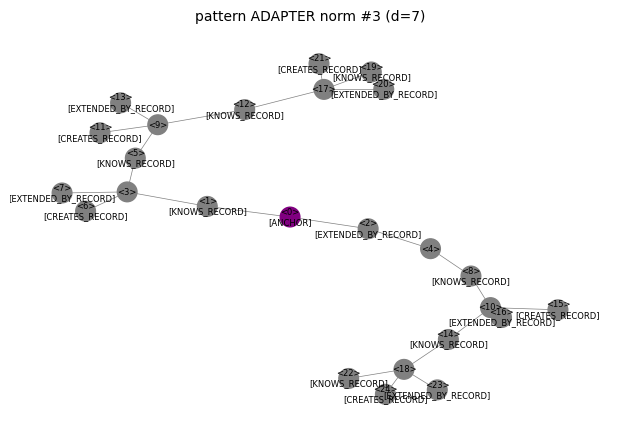

In [10]:
for idx, pattern in enumerate( dataset.get_patterns()[ dp_example_type ][ :3 ] ):
    pattern_norm, d = graph_utils.normalize_graph( pattern, max_distance=8 )
    plot_utils.plot_graph( pattern_norm, title=f"pattern {dp_example_type} norm #{idx + 1} (d={d})",
                           nodeLabels=graph_utils.get_node_labels( pattern_norm ),
                           nodeColors=graph_utils.get_node_colors( pattern_norm ) )

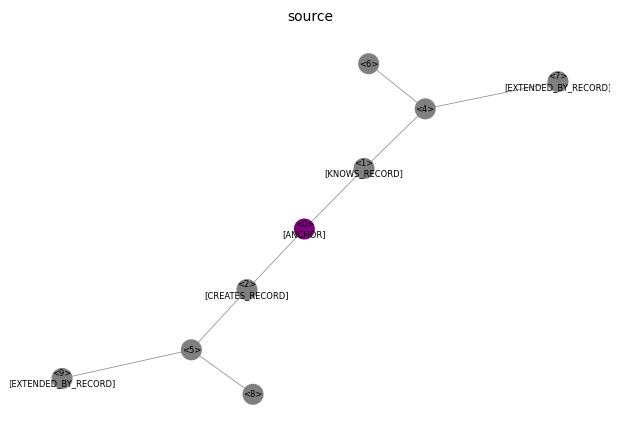

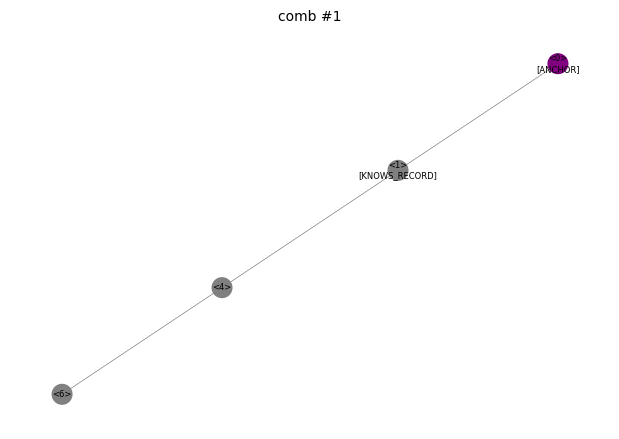

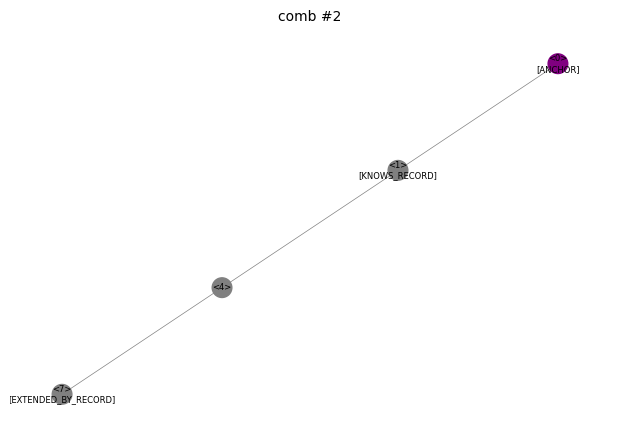

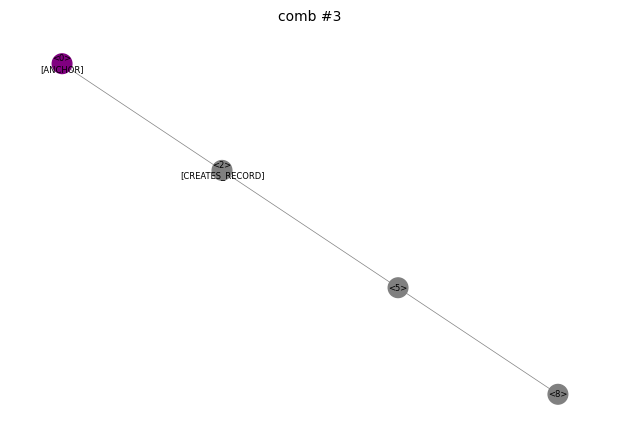

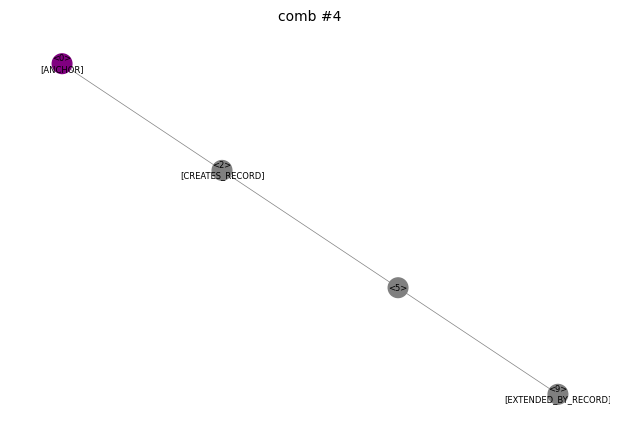

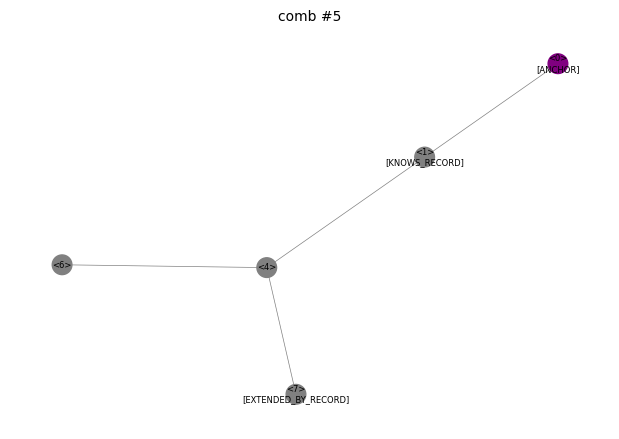

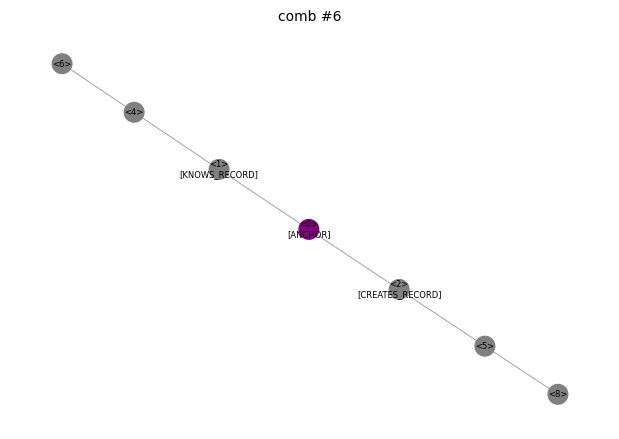

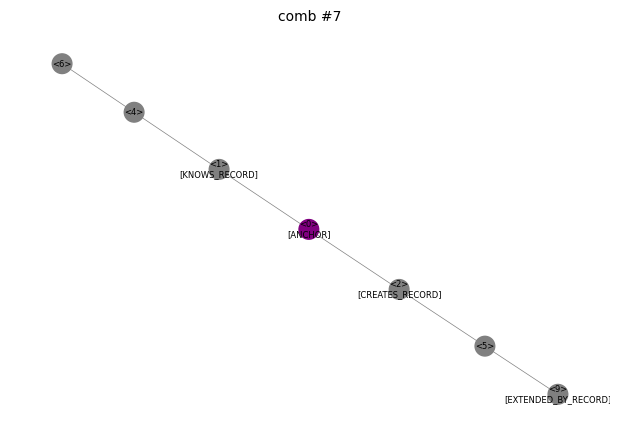

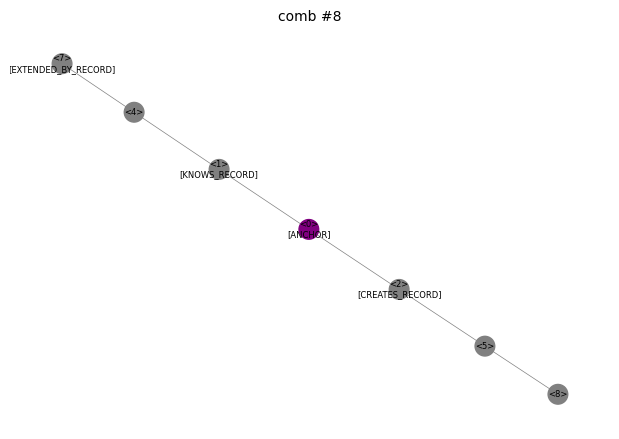

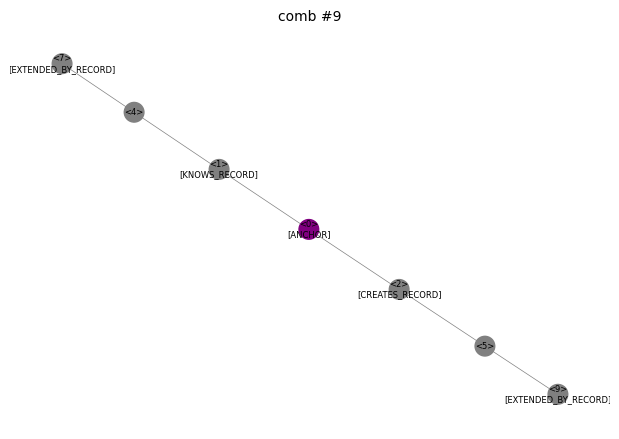

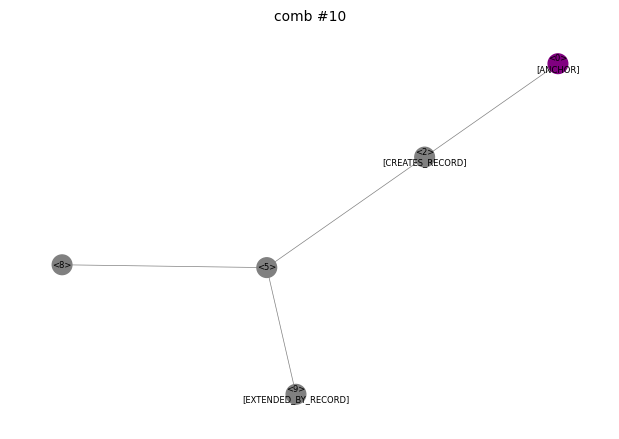

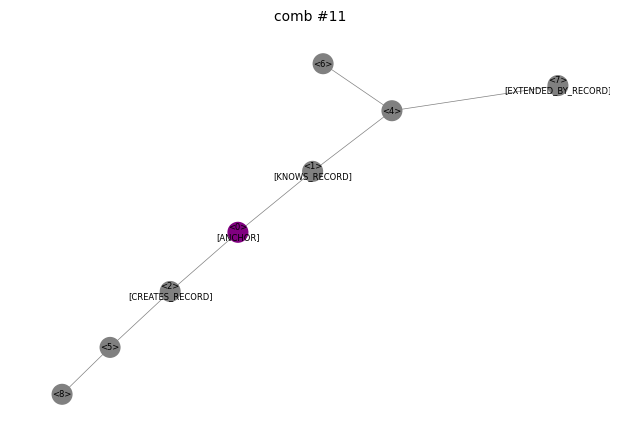

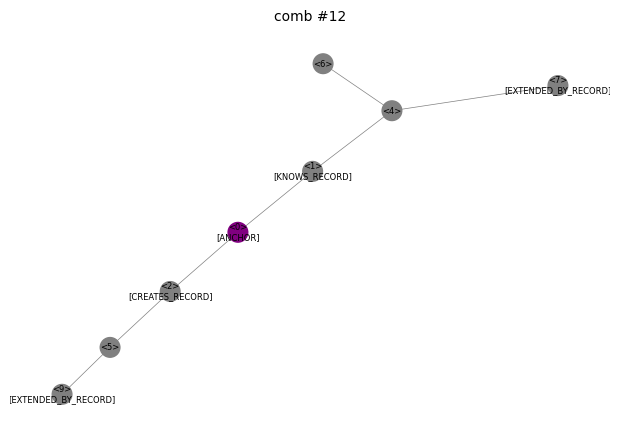

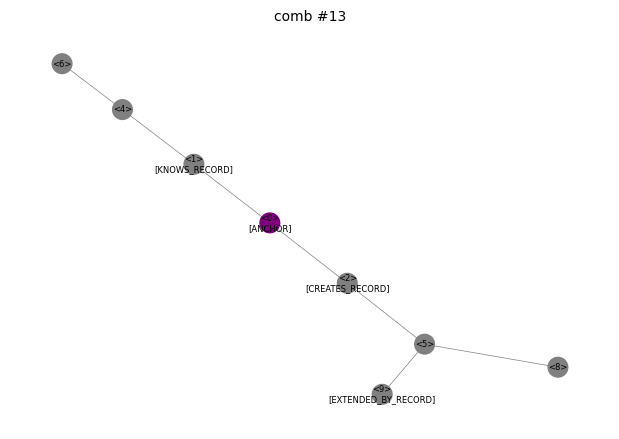

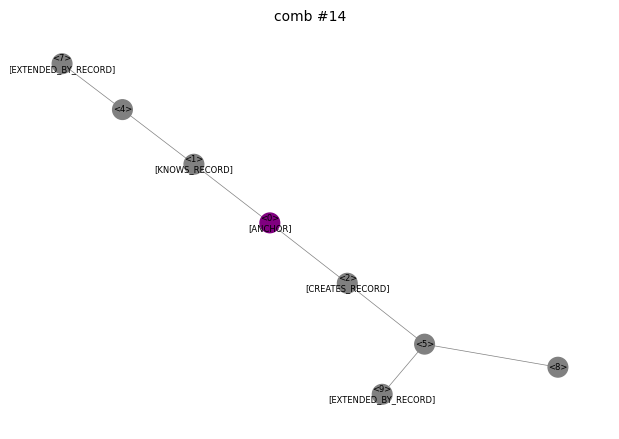

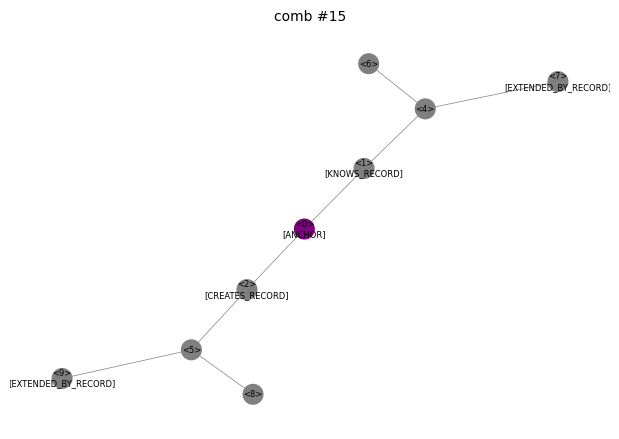

In [11]:
def gen_normalized_path_combinations( G, max_d=-1, n_min=-1, n_max=-1 ):
    paths = graph_utils.get_all_norm_paths( G )
    if max_d > 0:
        paths = [ (np[ :max_d + 1 ], lp[ :max_d + 1 ]) for np, lp in paths ]
        path_distinct = { lp: np for np, lp in paths }
        paths = [ (path_distinct[ lp ], lp) for lp in path_distinct.keys() ]

    if n_max < 0:
        n_max = len( paths )
    path_combinations = [ ]
    for size in range( max( n_min, 1 ), n_max + 1 ):
        path_combinations.extend( combinations( paths, size ) )
    combination_graphs = [ ]
    for path_combination in path_combinations:
        node_subset = [ ]
        for n_path, _ in path_combination:
            node_subset.extend( [ *n_path ] )
        combination_graphs.append( G.subgraph( set( node_subset ) ) )
    return combination_graphs


plot_utils.plot_graph( G_source, title="source",
                       nodeLabels=graph_utils.get_node_labels( G_source ),
                       nodeColors=graph_utils.get_node_colors( G_source ) )
for idx, graph in enumerate( gen_normalized_path_combinations( G_source, max_d=-1 ) ):
    plot_utils.plot_graph( graph, title=f"comb #{idx + 1}",
                           nodeLabels=graph_utils.get_node_labels( graph ),
                           nodeColors=graph_utils.get_node_colors( graph ) )

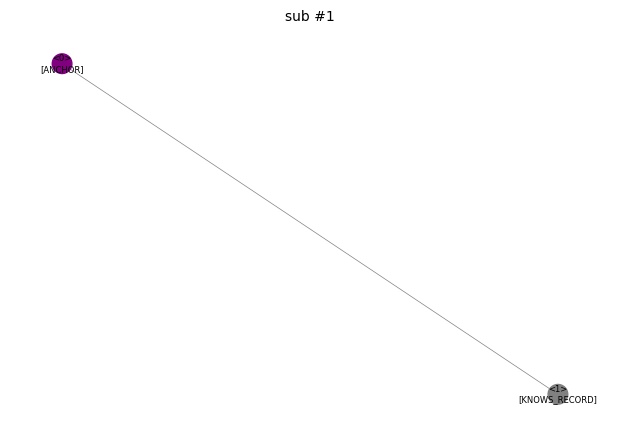

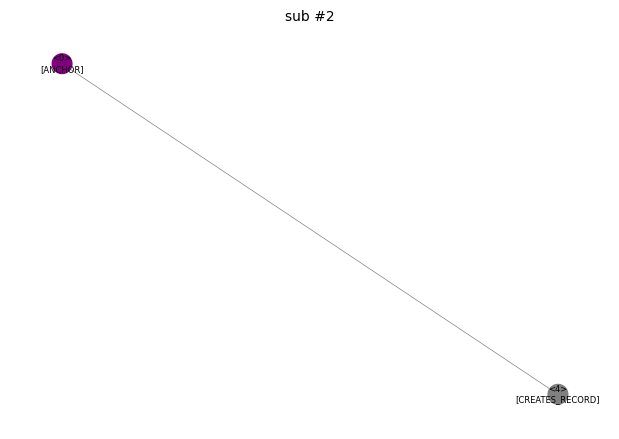

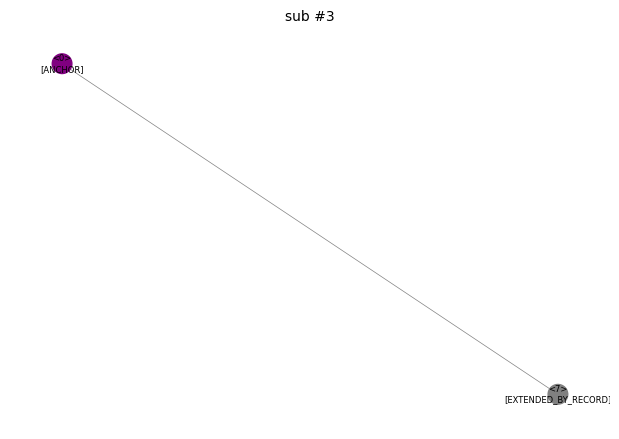

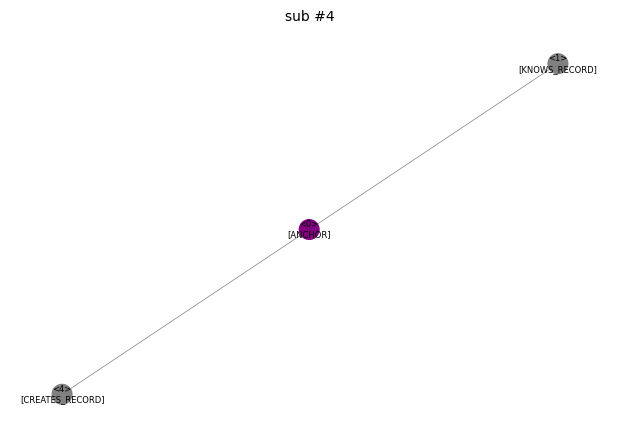

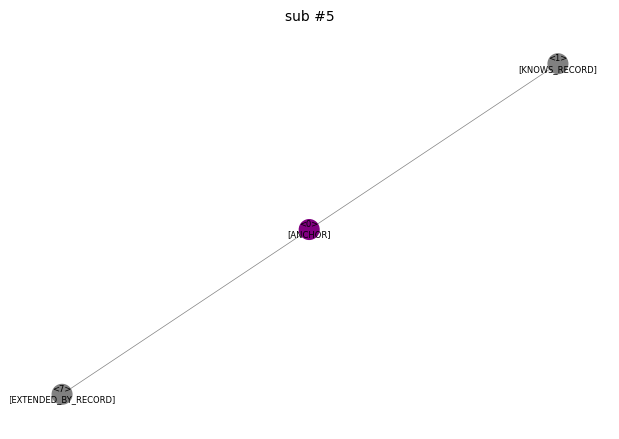

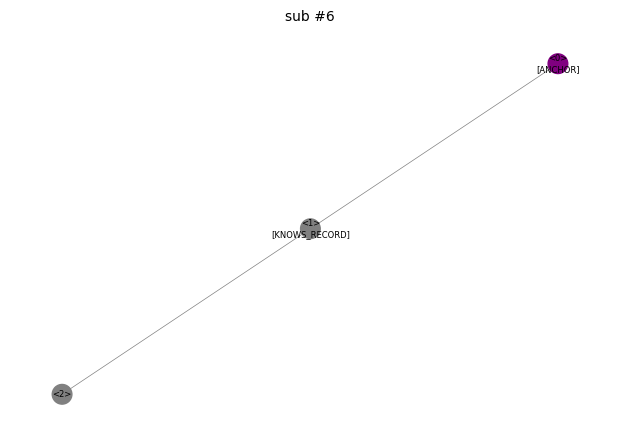

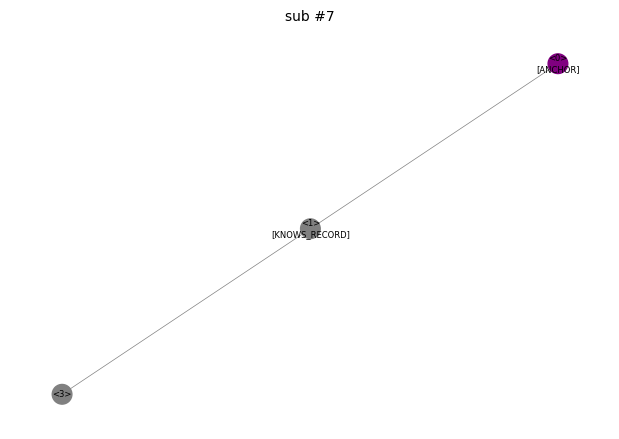

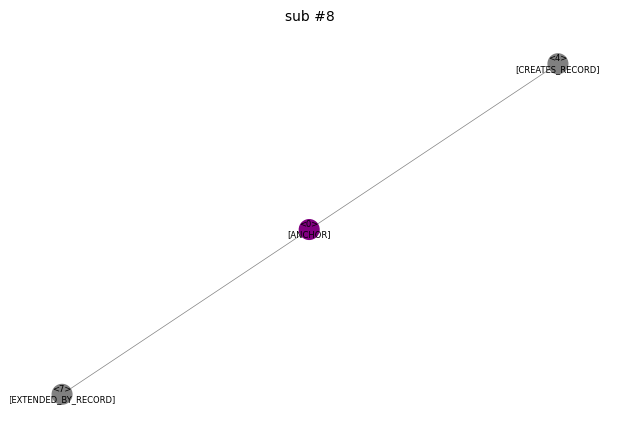

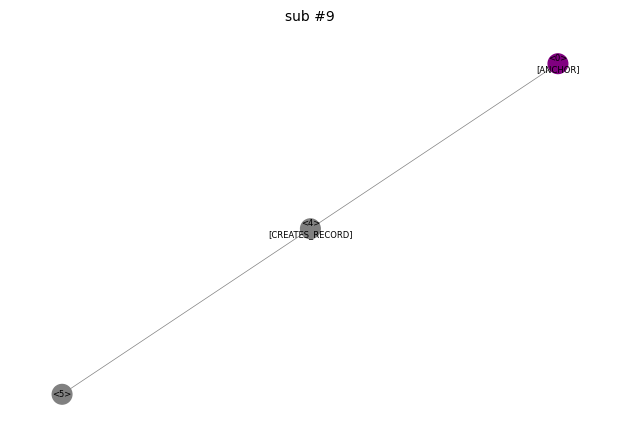

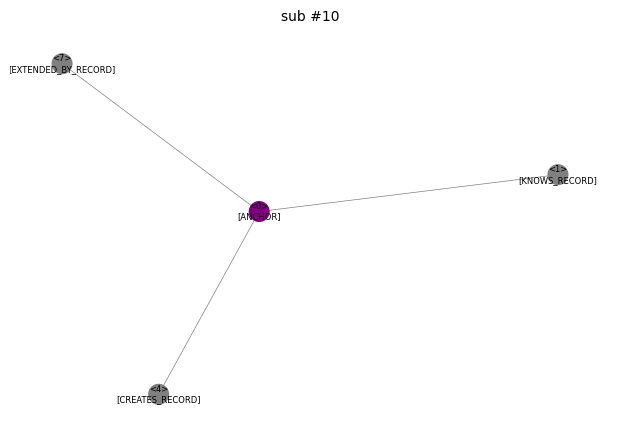

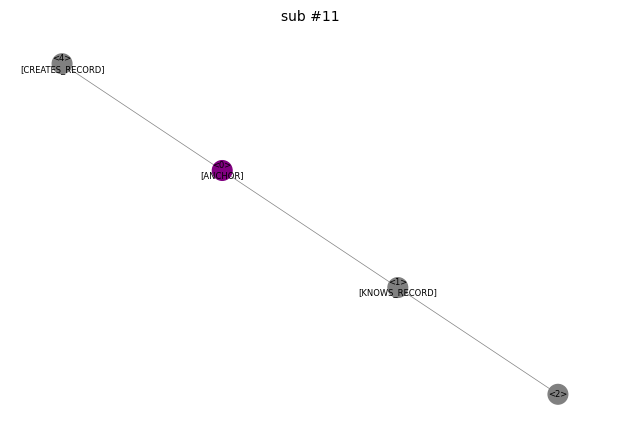

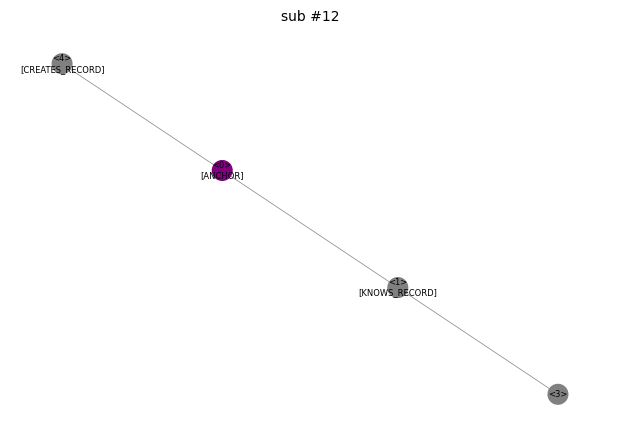

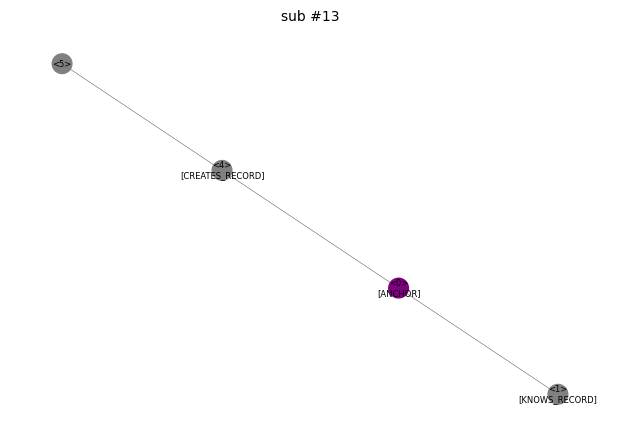

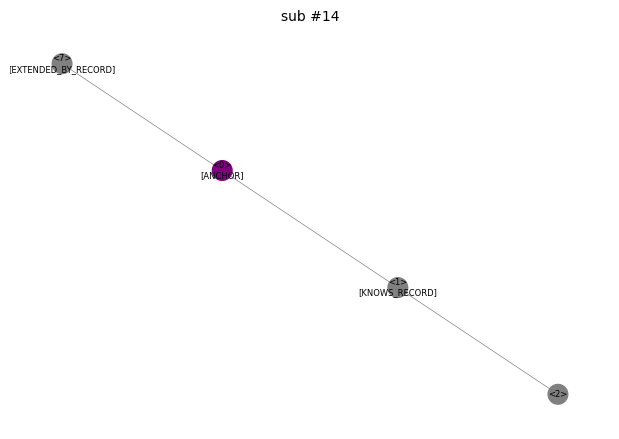

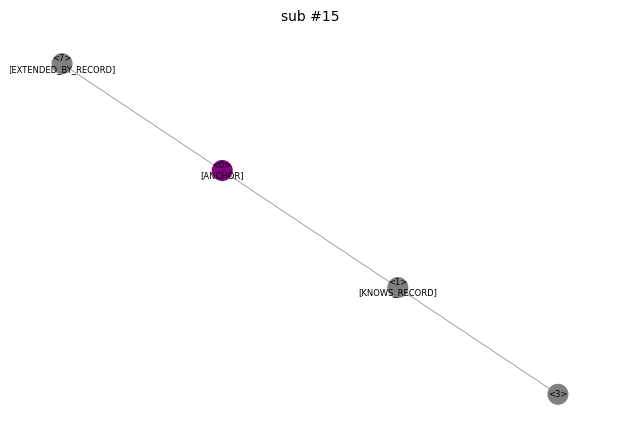

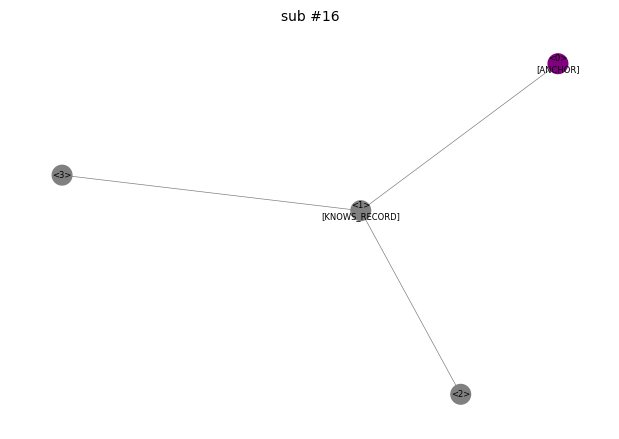

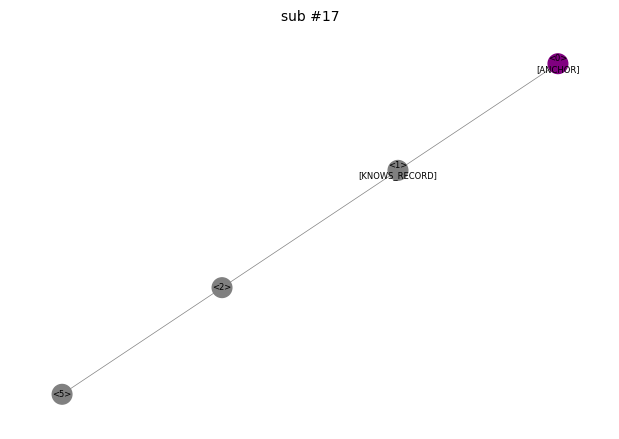

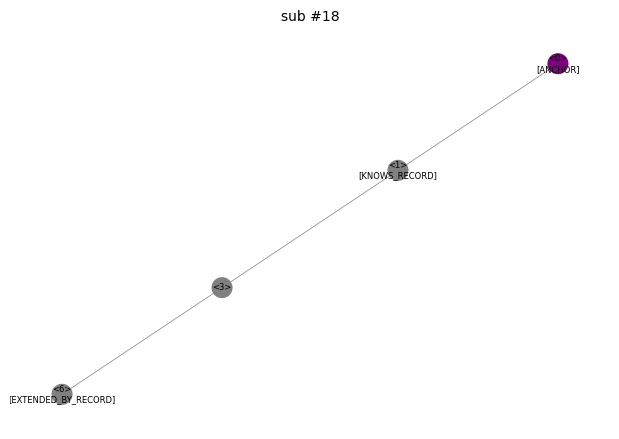

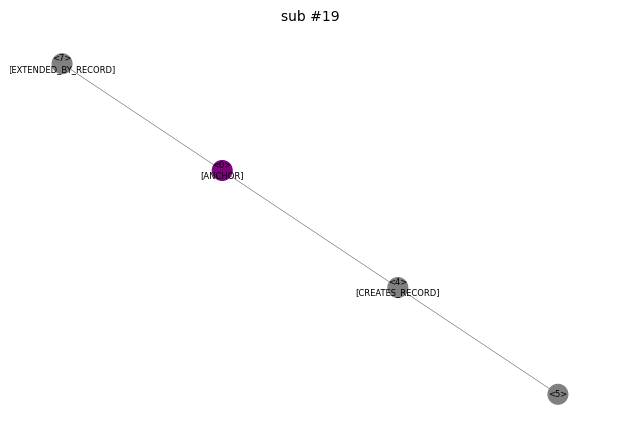

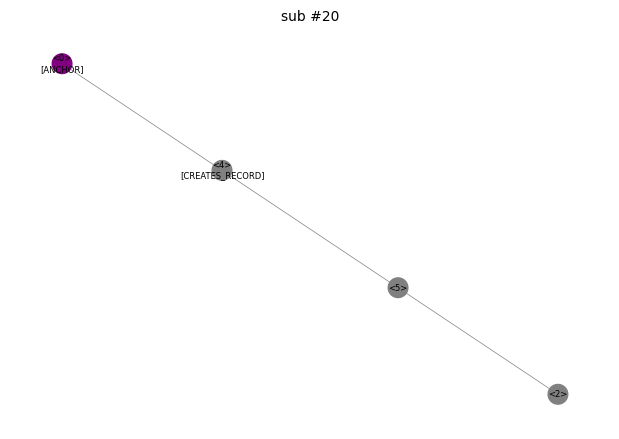

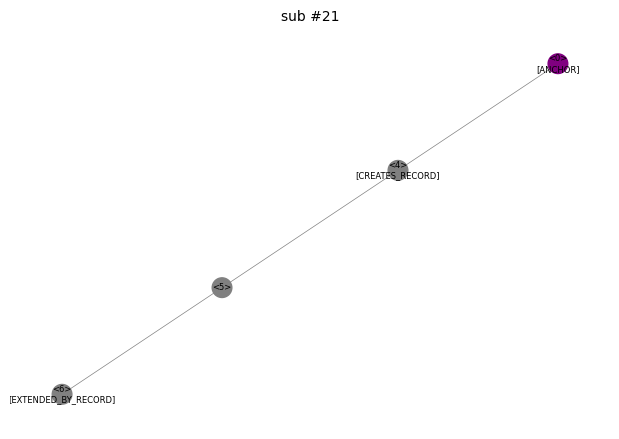

In [12]:
def compute_connected_subgraphs( G, a, n_min=-1, n_max=-1, total_max=-1 ):
    bfs_nodes = list( nx.bfs_tree( G, source=a ).nodes )
    subgraphs = [ ]
    if n_max < 0:
        n_max = len( bfs_nodes )
    for size in range( max( n_min, 1 ), n_max + 1 ):
        for subset in combinations( bfs_nodes, size ):
            subgraph = G.subgraph( subset )
            if nx.is_connected( subgraph ) and a in subgraph.nodes:
                subgraphs.append( subgraph.copy() )
                if total_max > 0 and len( subgraphs ) >= total_max:
                    return subgraphs

    return subgraphs

for idx, subgraph in enumerate( compute_connected_subgraphs( G, graph_utils.get_anchor( G ), n_min=2, n_max=4 ) ):
    plot_utils.plot_graph( subgraph, title=f"sub #{idx + 1}",
                           nodeLabels=graph_utils.get_node_labels( subgraph ),
                           nodeColors=graph_utils.get_node_colors( subgraph ) )

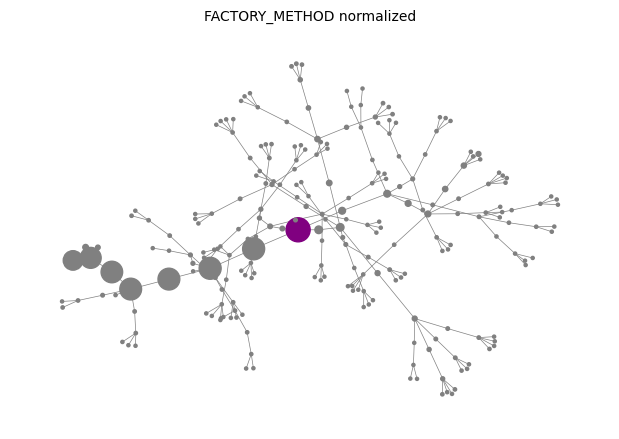

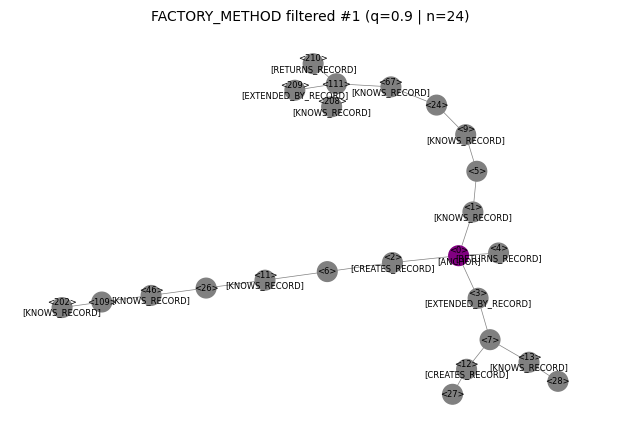

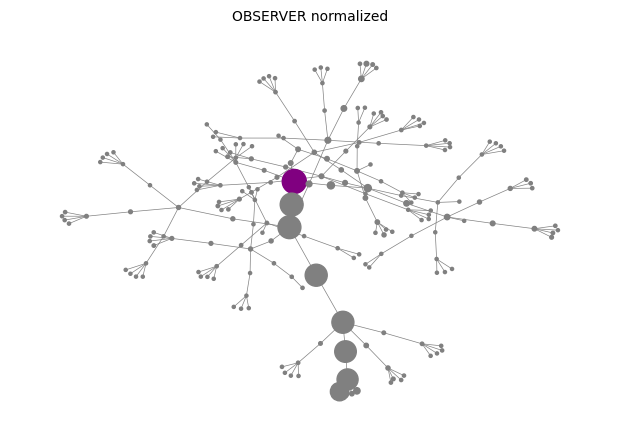

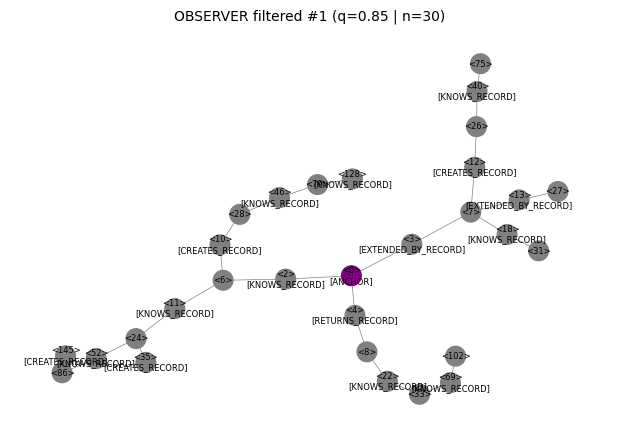

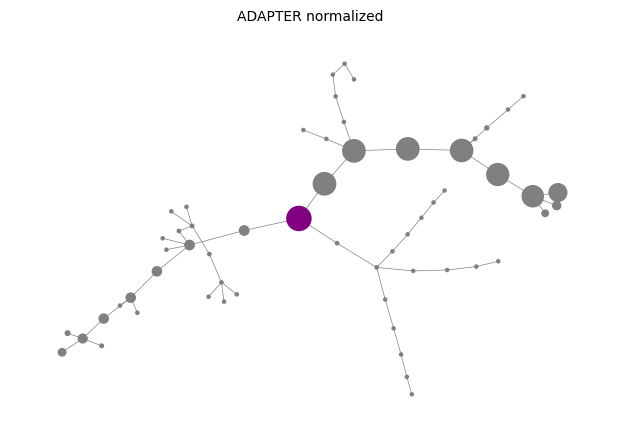

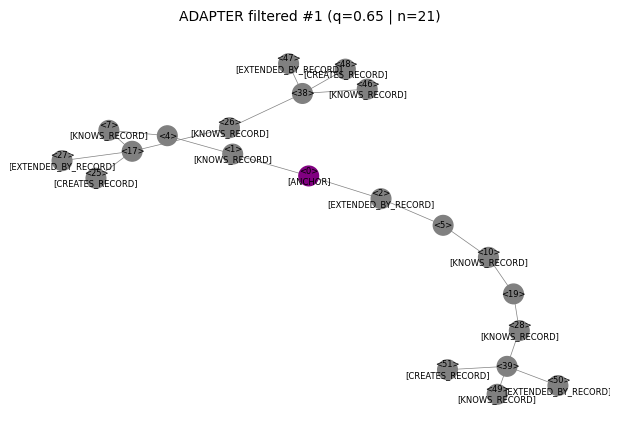

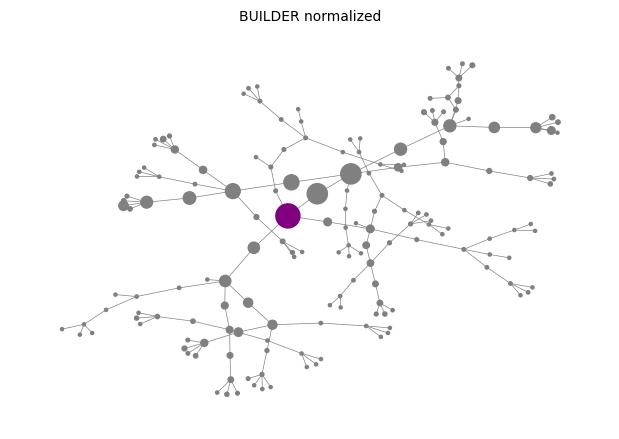

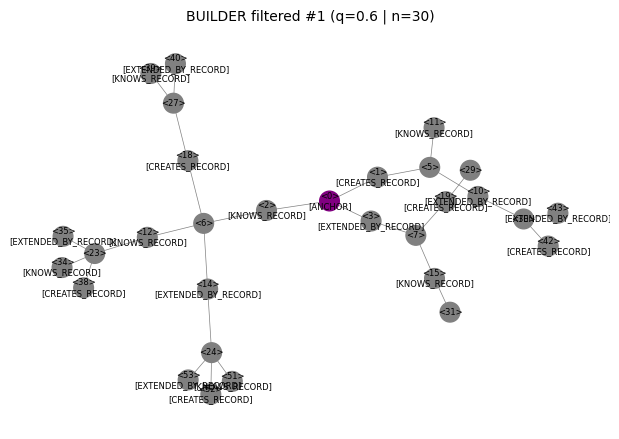

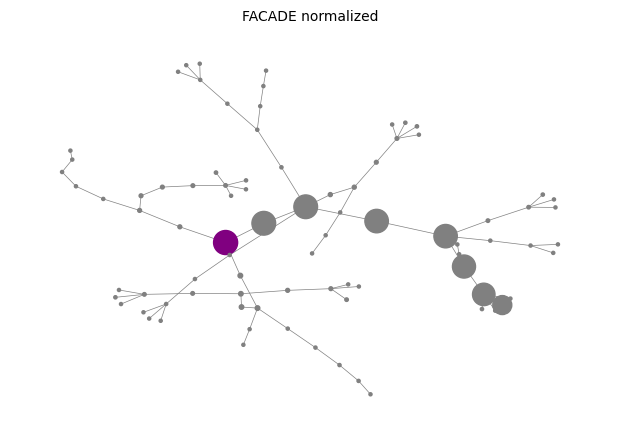

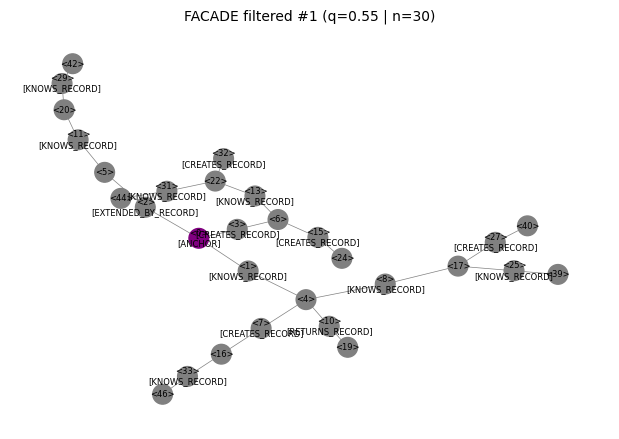

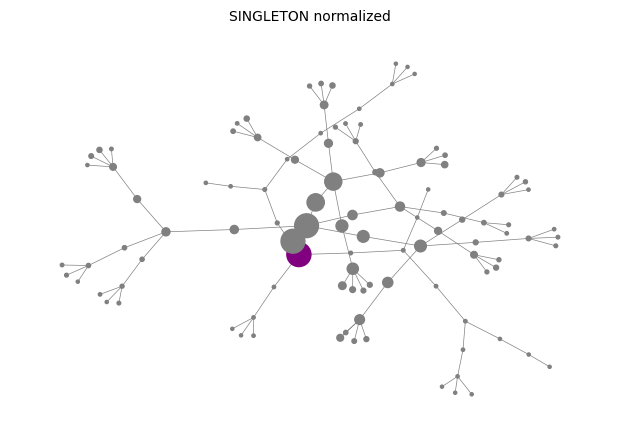

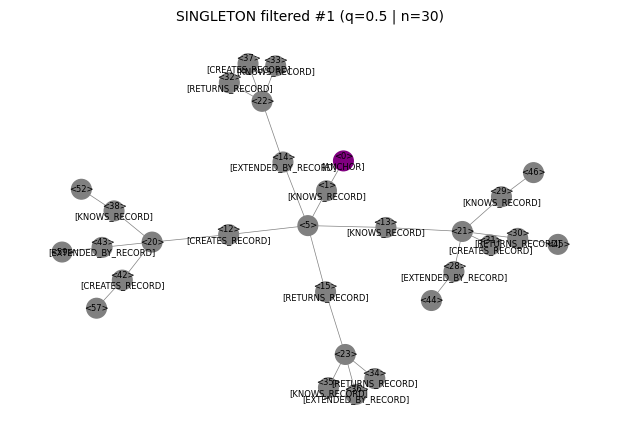

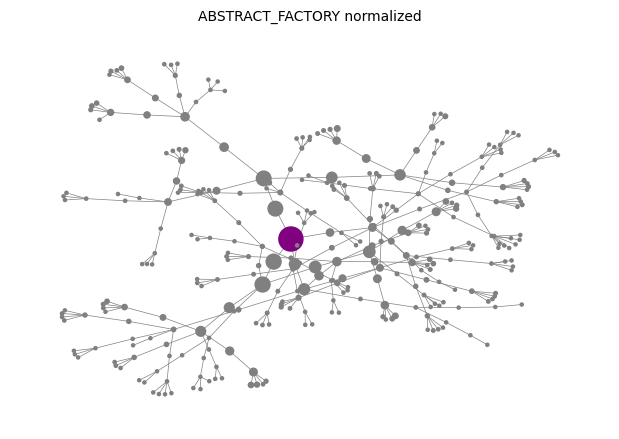

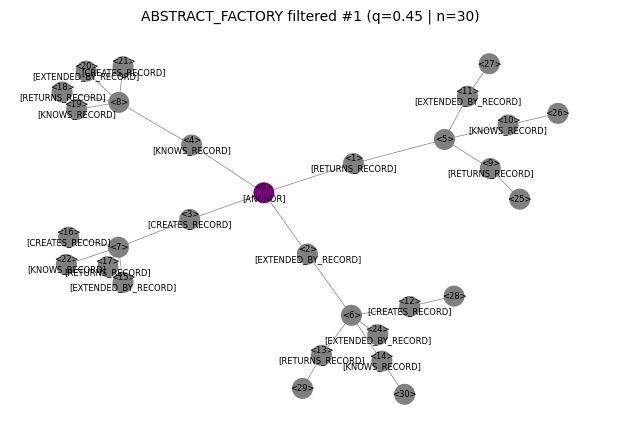

In [13]:
#patterns = epm.normalize_patterns( dataset, inplace=False, max_distance=8 )
patterns = dataset.get_patterns()
norm_graphs = epm.normalize_pattern_to_connected( patterns, max_distance=8 )
filtered_graphs, filtered_qs = epm.filter_normalized_connected_patterns( norm_graphs, num_graphs=1, 
                                                                         n_min=20, cut_at_n=30,
                                                                         q=0.95, q_step=0.05 )

for dp_type in norm_graphs.keys():
    normalized = norm_graphs[ dp_type ]
    node_presence = [ data[ "presence" ] for n, data in normalized.nodes( data=True ) ]
    node_sizes = misc_utils.map_num_array_to_range( node_presence, r_min=5, r_max=300 )
    plot_utils.plot_graph( normalized, title=f"{dp_type} normalized",
                           nodeLabels=graph_utils.get_node_labels( normalized ),
                           nodeColors=graph_utils.get_node_colors( normalized ),
                           with_label=False, node_sizes=node_sizes )

    for idx, filtered in enumerate( filtered_graphs[ dp_type ] ):
        q = filtered_qs[ dp_type ][ idx ]
        plot_utils.plot_graph( filtered, title=f"{dp_type} filtered #{idx + 1} (q={q:.2} | n={filtered.number_of_nodes()})",
                               nodeLabels=graph_utils.get_node_labels( filtered ),
                               nodeColors=graph_utils.get_node_colors( filtered ) )